In [5]:

#PYTHON 3.11 PARA EL TKINTER

import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
#import kbhit 
import time # para medir tiempos de ejecución
from tkinter import *

In [6]:
from osc import *

SRATE, CHUNK = 48000, 1024

In [3]:

# CLASE MODULADOR
class Modulator:
    def __init__(self, signal, freq=1, v0=0, v1=1):
            self.freq = freq
            self.frame = 0
            self.signal = signal
            self.osc = Osc(self.freq, v1-v0,self.frame+CHUNK)
            self.v0 = v0
            self.v1 = v1

            #genera una moduladora
            self.mod = Osc(freq)

    def next(self): 

        #se multiplican las señales
        out =((self.v1-self.v0)*self.mod.next()+(self.v1+self.v0))/2
        #
        #normaliza y reubica, el offset es para moverlo primero del [-1,1] al positivo
        #el /2 es para re escalar porque el rango ees de dos al principio y pasa a ser de 1

        self.frame += CHUNK
        return out * self.signal.next()


In [3]:
class Osc2:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out
    

    #frecuencia
    def getFreq(self):
        return self.freq
    
    def setFreq(self, newFreq):
        self.freq = newFreq

    #volumen
    def getAmp(self):
        return self.amp

    def setAmp(self, vol):
        self.amp = vol


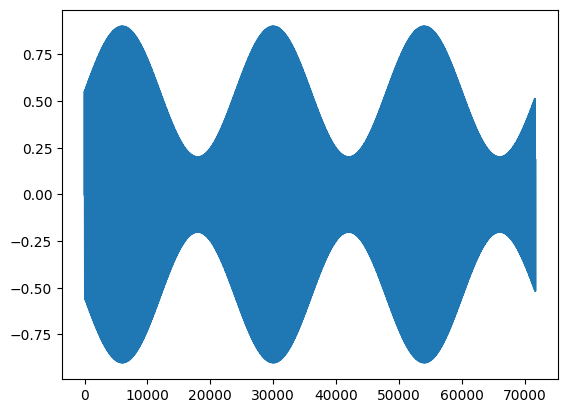

In [5]:


# señal que vamos a modular
signal = Osc(freq=440)
# con un modulador de 2 Hz y amplitud en [0.2,0.9]
mod = Modulator(signal,freq=2,v0=.2,v1=.9)
# generamos 1.5 segundos de señal modulada
time = 1.5
chunks = int(time*SRATE/CHUNK) # número de chunks a generar
signal = np.empty(0) # acumulador de la señal
for i in range(chunks): # generamos los chunks
    signal = np.append(signal,mod.next())

sd.play(signal, SRATE)
sd.wait()
plt.plot(signal)

In [6]:

# señal que vamos a modular
signal = Osc2(freq=440)
# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

v = np.empty(0) # acumulador de la señal
for i in range(chunks): # generamos los chunks
    v = np.append(v,signal.next())

sd.play(v, SRATE)
sd.wait()

In [7]:
def callback(outdata, farmes, time, status):
    v = np.zeros(0)
    for i in range(chunks):
        v = np.append(v, signal.next())
    sd.play(v)
    sd.wait()

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

root=Tk()

text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"V/v volume\n")


# call back para la pulsación de teclas
def key_down(event):
    global signal  # conexión con sounddevice
    if event.char=='v': 
        print('volume down')
        if signal.getAmp() > 0:
            signal.setAmp(signal.getAmp() - 0.1)
    elif event.char=='V': 
        print('volume up')
        if signal.getAmp() < 100:
            signal.setAmp(signal.getAmp() + 0.1)
        #input = Note(amp=0.6,release=2)  # enrutamos la señal de la nota al "input" del stream
    elif event.char=='f': 
        print('frecuency down')
        signal.setFreq(signal.getFreq() - 110)
    elif event.char=='F': 
        print('frecuency up')
        signal.setFreq(signal.getFreq() + 110)
    elif event.char==' ': 
        print('note deactivated')



text.bind('<Key>', key_down)



root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

In [ ]:
# ejercicio 3 (entregable)

class OscFM2:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0
        # moduladora = βsin(2πfm)
        self.mod = Osc(freq=fm,amp=beta)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = Osc(self.fm,self.beta).next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 

    #moduladora
    def getFM(self):
        return self.fm
    
    def setFM(self, newFM):
        self.fm = newFM

    #beta
    def getBeta(self):
        return self.beta

    def setBeta(self, beta):
        self.beta = beta



# señal que vamos a modular
signal = OscFM2()
# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar
v = np.empty(0) # acumulador de la señal
for i in range(chunks): # generamos los chunks
    v = np.append(v,signal.next())

sd.play(v, SRATE)
sd.wait()

In [18]:
def callback(outdata, farmes, time, status):
    v = np.zeros(0)
    for i in range(chunks):
        v = np.append(v, signal.next())
    sd.play(v)
    sd.wait()

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

root=Tk()

text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"B/b beta\n")


# call back para la pulsación de teclas
def key_down(event):
    global signal  # conexión con sounddevice
    if event.char=='b': 
        print('beta down')
        if signal.getBeta() > 0:
            signal.setBeta(signal.getBeta() - 0.1)
    elif event.char=='B': 
        print('beta up')
        if signal.getBeta() < 1:
            signal.setBeta(signal.getBeta() + 0.1)
    elif event.char=='m': 
        print('fm down')
        signal.setFM(signal.getFM() - 200)
    elif event.char=='M': 
        print('fm up')
        signal.setFM(signal.getFM() + 200)
    elif event.char==' ': 
        print('note deactivated')

text.bind('<Key>', key_down)

root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()



# 

fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm down
fm up
fm up
fm up
fm up
fm up
fm up
fm up
fm up
beta down
note deactivated
note deactivated
note deactivated
note deactivated
beta up
beta up
beta up


In [ ]:
# ejercicio 7

class Delay:
    def __init__(self, ret):
        self.delayn = ret


    def delay(self, signal):
        # calcula el nuevo size de la signal
        # wdelay = int(self.time*SRATE/CHUNK)

        # genera un array con el size
        ssignal = np.zeros(self.delayn * SRATE)

        # porque:
        # wdelay = time * SRATE/CHUNK
        # size = wdelay * CHUNK

        # wdelay * CHUNK = time * SRATE = size

        #rellena el array
        ssignal = np.append(ssignal, signal)

        return ssignal
    

    def next(self, chunk):

        chu = chunk
        return chu


# guarda la señal en un buffer
# delay tiene una cola de chunks y la señal que le da la va pegando CHUNK A CHUNK en el final

# señal que vamos a modular
signal = Osc2()

delayed = Delay(3)

sol = delayed.delay(signal)

#sd.play(sol)
sd.wait()
plt.plot(sol)


TypeError: 'int' object is not callable

In [ ]:
#ejercicio 8 theremin


import tkinter as tk

WIDTH, HEIGHT = 800, 600


# señal que vamos a modular
signal = OscFM2()
# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

def callback(outdata, farmes, time, status):
    v = np.zeros(0)
    for i in range(chunks):
        v = np.append(v, signal.next())


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

root = tk.Tk()
root.geometry(f"{WIDTH}x{HEIGHT}")

def motion(event):
    x = root.winfo_pointerx()
    y = root.winfo_pointery()


    #reajusta la onda

    
    print(f'{x}, {y}')


root.bind('<Motion>', motion)
root.mainloop()

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
244, 194
251, 194
260, 195
270, 196
278, 196
 
 
286, 196
296, 196
303, 196
312, 194
320, 194
326, 194
331, 194
 
 
336, 193
341, 193
344, 193
348, 193
 
 
360, 192
366, 192
373, 192
379, 193
386, 193
392, 194
 
 
400, 194
407, 194
417, 195
426, 196
438, 198
458, 203
 
 
526, 221
622, 250
667, 266
711, 285
755, 302
791, 317
822, 330
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
830, 281
830, 274
829, 265
 
 
829, 258
829, 254
829, 250
829, 246
829, 243
 
 
829, 241
829, 236
829, 233
829, 227
829, 224
828, 218
828, 214
827, 210
 
 
827, 206
827, 202
827, 200
827, 198
827, 193
828, 190
829, 187
830, 183
831, 177
832, 170
 
 
 
 
 
 
 
 
 
 
829, 66
827, 65
 
 
826, 65
826, 64
825, 63
824, 63
823, 63
 
 
823, 62
 
 
 
 
823, 61
823, 60
823, 59
823, 58
 
 
823, 57
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
